In [24]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [25]:
df=pd.read_csv('diabetes.csv')

In [26]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [27]:
df.shape

(768, 9)

<Axes: xlabel='Outcome', ylabel='count'>

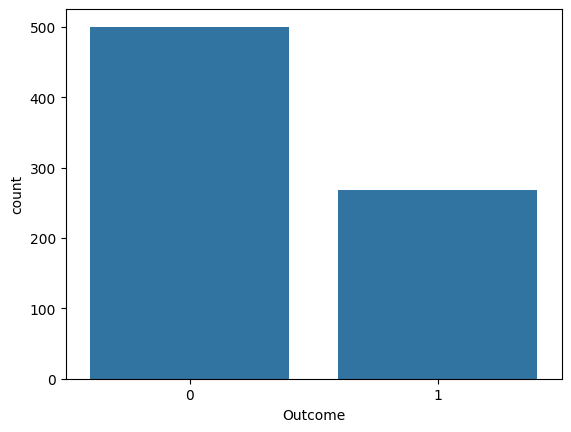

In [28]:
sns.countplot(x=df['Outcome'])

In [29]:
con_col=['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

In [30]:
cols_with_zero_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zero_missing:
    means=df[col].mean()
    df[col] = df[col].replace(0, means)

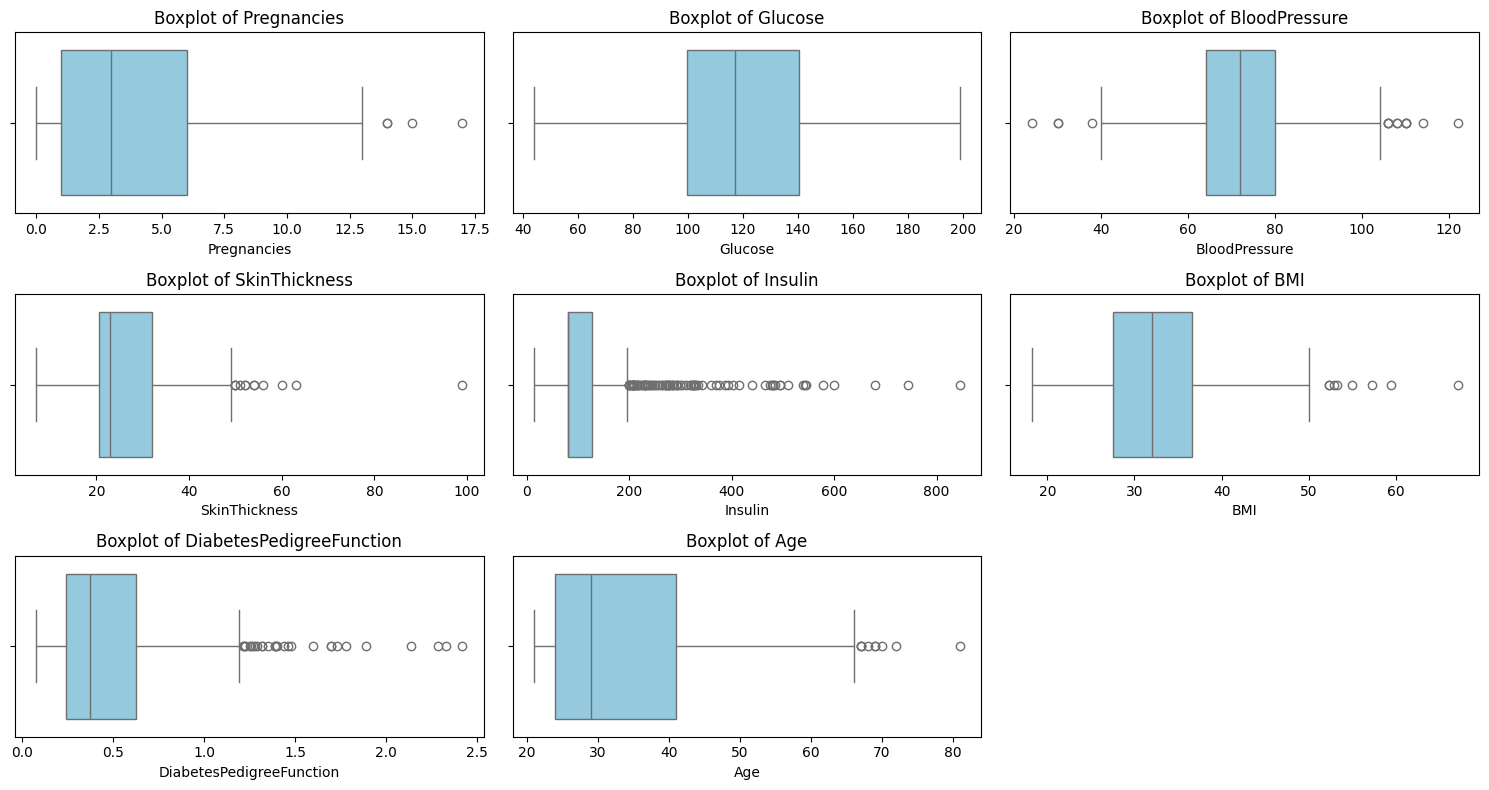

In [31]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


In [32]:
def replace_outliers(df, cols):
    df_capped = df.copy()
    for col in cols:
        means=df[col].mean()
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_capped[col] = np.clip(df[col], lower, upper)
    return df_capped

In [33]:
diabetes_capped = replace_outliers(df, con_col)

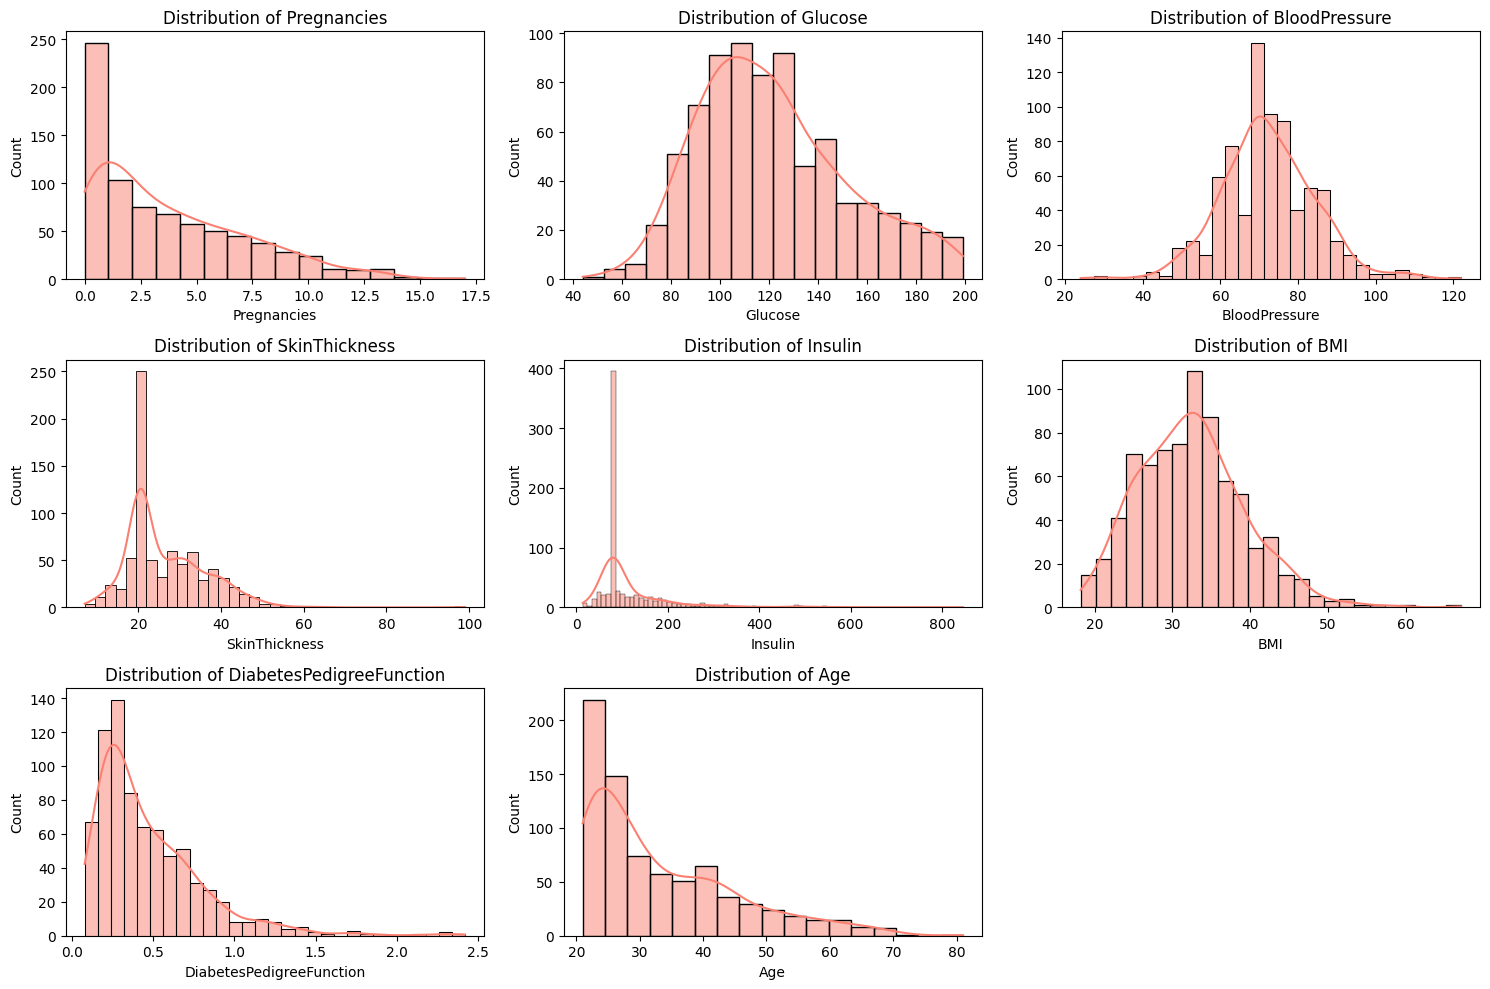

In [34]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, color='salmon')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


In [35]:
con_col

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [36]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
# Fit on numeric columns only
diabetes_capped[con_col] = pt.fit_transform(diabetes_capped[con_col])

In [37]:
import pickle
with open('Transformation.pkl', 'wb') as f:
        pickle.dump(pt, f)


In [38]:
df=diabetes_capped

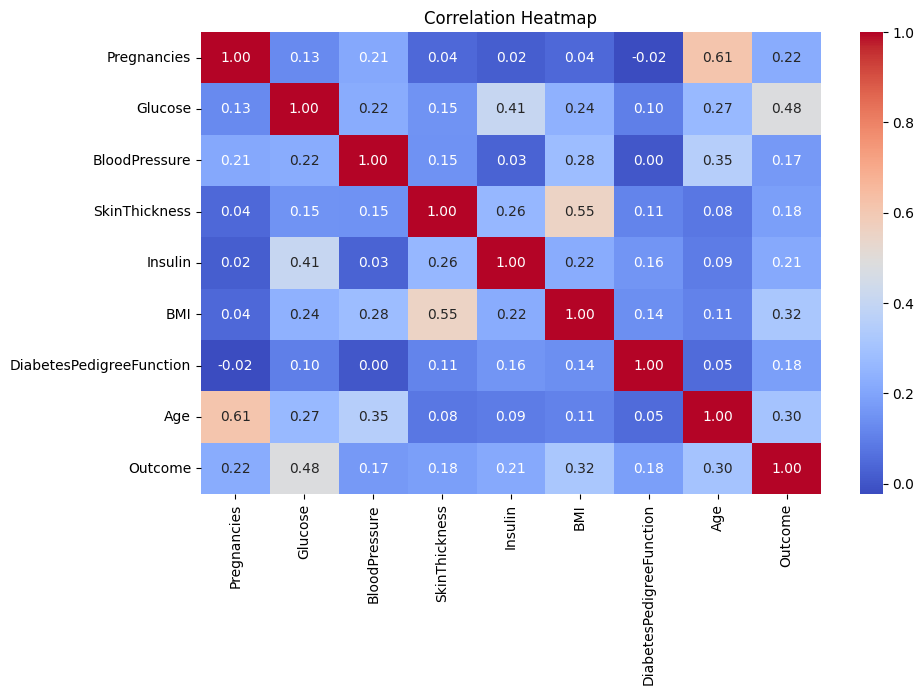

In [39]:
plt.figure(figsize=(10, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


# Model-Fit

In [40]:
X=df.drop('Outcome',axis=1)
y=df['Outcome']

In [41]:
from imblearn.over_sampling import RandomOverSampler
smote = RandomOverSampler()
X_train_res, y_train_res = smote.fit_resample(X, y)
X=X_train_res
y=y_train_res

In [42]:
from sklearn.preprocessing import StandardScaler
num_cols = X.select_dtypes(include=['number']).columns.tolist()
scaler=StandardScaler()
X[num_cols]=scaler.fit_transform(X[num_cols])

In [43]:
with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)


In [44]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)

In [45]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pickle

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier()
}

results = {}
best_model = None
best_name = None
best_acc = 0.0

# Start an MLflow experiment
mlflow.set_experiment("Diabetes_Classification_Comparison")

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        try:
            # Train model
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            results[name] = acc

            # Log metrics
            mlflow.log_metric("accuracy", acc)

            # Log model
            mlflow.sklearn.log_model(model, artifact_path="model")

            print(f"{name}: {acc:.4f}")

            # Track best model
            if acc > best_acc:
                best_acc = acc
                best_name = name
                best_model = model

        except Exception as e:
            print(f"{name}:  Error - {e}")
            mlflow.log_param("error", str(e))

print("\nResults:")
for name, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {acc:.4f}")



2025/10/27 20:50:18 INFO mlflow.tracking.fluent: Experiment with name 'Diabetes_Classification_Comparison' does not exist. Creating a new experiment.
2025/10/27 20:50:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/27 20:50:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression: 0.7400


2025/10/27 20:50:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/27 20:50:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Naive Bayes: 0.7500


2025/10/27 20:50:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/27 20:50:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest: 0.8700


2025/10/27 20:50:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/27 20:50:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Gradient Boosting: 0.7950


2025/10/27 20:50:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/27 20:50:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


AdaBoost: 0.7300


2025/10/27 20:50:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/27 20:51:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost: 0.8150

Results:
Random Forest: 0.8700
XGBoost: 0.8150
Gradient Boosting: 0.7950
Naive Bayes: 0.7500
Logistic Regression: 0.7400
AdaBoost: 0.7300


In [46]:
if best_model is not None:
    with open('best_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    print(f"\nBest model '{best_name}' saved successfully with accuracy = {best_acc:.4f}")
else:
    print("\n No valid model was trained.")



Best model 'Random Forest' saved successfully with accuracy = 0.8700
